# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [1]:
%load_ext autoreload
%autoreload 2

# experiment

import numpy as np
import torch
from tqdm.auto import tqdm

SEED = 51505
STRATEGY = "random"

max_training_samples = 150  # TERMINATION CONDITION - i.e. STOP ACQUIRING ONCE WE HAVE THIS MANY
acquisition_batch_size = 5
num_inference_samples = 100  # MONTE CARLO DROPOUT ENSEMBLE SIZE FOR COMPUTING MARGINAL ENTROPY
num_test_inference_samples = 5  # ENSEMBLE SIZE FOR SCORING ON TEST SET
num_samples = 100000  # FOR BATCH BALD JOINT ENTROPY COMPUTATION... THIS IS WHY IT'S SLOW

test_batch_size = 512
batch_size = 64
scoring_batch_size = 128
training_iterations = 4096 * 6


assert STRATEGY in ["batch_bald", "bald", "random"]

np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
# experiment

import math

import torch
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
)

Let's define our Bayesian CNN model that we will use to train MNIST.

In [3]:
# experiment


class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
        input = input.view(-1, 1024)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input

Grab our dataset, we'll use Repeated-MNIST. We will acquire to samples for each class for our initial training set.

N.B. with num repetitions=1, we just have the standard MNIST dataset

In [4]:
# experiment
g = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

num_initial_samples = 20
num_classes = 10

initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset),
    num_classes=num_classes,
    n_per_digit=num_initial_samples / num_classes,
    generator=g,
)
initial_samples

[42166,
 38358,
 10065,
 48041,
 17784,
 50417,
 24155,
 40706,
 5445,
 41228,
 49514,
 33271,
 48070,
 52203,
 41623,
 1433,
 53689,
 3449,
 47520,
 9544]

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

For this example, we are going to take two shortcuts that will reduce the performance:
* we discard most of the training set and only keep 20k samples; and
* we don't implement early stopping or epoch-wise training.

Instead, we always train by drawing 24576 many samples from the training set. This will overfit in the beginning and underfit later, but it still is sufficient to achieve 90% accuracy with 105 samples in the training set. 

In [6]:
# experiment

use_cuda = torch.cuda.is_available()

print(f"use_cuda: {use_cuda}")

device = "cuda" if use_cuda else "cpu"

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(40000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")

while True:
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    
    if STRATEGY in ["batch_bald", "bald"]:
        logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

        with torch.no_grad():
            model.eval()

            for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
                data = data.to(device=device)

                lower = i * pool_loader.batch_size
                upper = min(lower + pool_loader.batch_size, N)
                logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

        if STRATEGY == "batch_bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_batchbald_batch(
                    logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
                )
        elif STRATEGY == "bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_bald_batch(
                    logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                )
    elif STRATEGY == "random":
        candidate_batch = batchbald.get_random_batch(N, acquisition_batch_size)
    else:
        raise ValueError(STRATEGY)

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

use_cuda: False


Training Set Size:  13%|#3        | 20/150 [00:00<?, ?it/s]

Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.9851, Accuracy: 6187/10000 (61.87%)
Dataset indices:  [56995 10784 40872 45144 10805]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([3, 9, 7, 9, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 2.1238, Accuracy: 6574/10000 (65.74%)
Dataset indices:  [32047 39019 40751 30187 47038]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 6, 6, 0, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 2.1019, Accuracy: 6643/10000 (66.43%)
Dataset indices:  [29903 55405 58432 28676 48007]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([0, 8, 4, 9, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.5401, Accuracy: 7168/10000 (71.68%)
Dataset indices:  [38099 53828 48398  1473 37297]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([0, 6, 6, 4, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.5810, Accuracy: 7278/10000 (72.78%)
Dataset indices:  [26895 32421 53603 32811  7222]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 3, 6, 3, 1])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.6564, Accuracy: 7147/10000 (71.47%)
Dataset indices:  [14851 34695 10841 18674  5894]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([3, 3, 7, 8, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.6313, Accuracy: 7654/10000 (76.54%)
Dataset indices:  [12919 18579 24924 41999 27108]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([6, 9, 1, 0, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.6948, Accuracy: 7537/10000 (75.37%)
Dataset indices:  [31170 18774 49995 33580 35997]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 8, 5, 1, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.1623, Accuracy: 7721/10000 (77.21%)
Dataset indices:  [47446 58268 34268  2272 42811]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([1, 3, 3, 5, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.0700, Accuracy: 7728/10000 (77.28%)
Dataset indices:  [10689  8142 31991 46485  6063]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([0, 7, 7, 3, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.7106, Accuracy: 8185/10000 (81.85%)
Dataset indices:  [44018 25364  6252 33405 28123]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([5, 1, 2, 7, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.7328, Accuracy: 8341/10000 (83.41%)
Dataset indices:  [20243 51323  9821  6009 53773]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([3, 2, 4, 4, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6884, Accuracy: 8326/10000 (83.26%)
Dataset indices:  [ 2958 51354 56893 58543 20325]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([8, 6, 4, 8, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.5772, Accuracy: 8540/10000 (85.40%)
Dataset indices:  [47178 14535 58274 16145 17352]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 3, 9, 8, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6109, Accuracy: 8535/10000 (85.35%)
Dataset indices:  [55467 43888 10288  2205 50530]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([7, 9, 5, 2, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.5770, Accuracy: 8555/10000 (85.55%)
Dataset indices:  [35506 27044 26995 19797 12718]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 4, 5, 5, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4898, Accuracy: 8784/10000 (87.84%)
Dataset indices:  [16574 21565 17565 46384 58341]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([5, 6, 4, 4, 1])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4525, Accuracy: 8848/10000 (88.48%)
Dataset indices:  [ 1230 53691 19450 27532 39721]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([1, 3, 2, 7, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4582, Accuracy: 8859/10000 (88.59%)
Dataset indices:  [51028 42917 54098 14016 42833]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([4, 5, 9, 1, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4398, Accuracy: 8921/10000 (89.21%)
Dataset indices:  [42036 43620 56601 54209  9481]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([7, 6, 7, 0, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4447, Accuracy: 8920/10000 (89.20%)
Dataset indices:  [46420 47893 16650 56353 24449]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([6, 7, 2, 0, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4252, Accuracy: 8956/10000 (89.56%)
Dataset indices:  [37934 27530 15857 44701 55591]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([9, 6, 3, 9, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4159, Accuracy: 8993/10000 (89.93%)
Dataset indices:  [ 5169  8369  3222  7277 48602]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([1, 0, 4, 7, 0])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4273, Accuracy: 9023/10000 (90.23%)
Dataset indices:  [10797 45392 43423 23699 48298]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([8, 7, 0, 6, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4291, Accuracy: 8956/10000 (89.56%)
Dataset indices:  [26427 26947 23063 41940 55276]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([0, 8, 8, 6, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3754, Accuracy: 9034/10000 (90.34%)
Dataset indices:  [18392  1228 16715 44269 24229]
Scores:  [1.0, 1.0, 1.0, 1.0, 1.0]
Labels:  tensor([7, 6, 3, 1, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3909, Accuracy: 9027/10000 (90.27%)


In [13]:
test_loss = torch.stack(test_loss).tolist()

In [16]:
np.savez("rnd_51505", test_loss=test_loss, test_accs=test_accs, added_indices=added_indices)

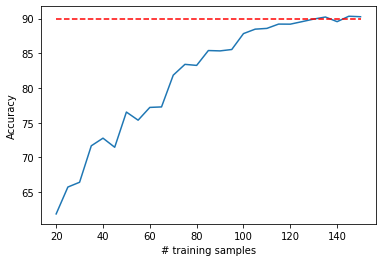

In [10]:
# experiment
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs)
plt.xlabel("# training samples")
plt.ylabel("Accuracy")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.show()